In [66]:
import matplotlib
from matplotlib import pyplot
import numpy as np

import sys
sys.path.append("..")
from hiora_cartpole import features
from hiora_cartpole import fourier_fa
from hiora_cartpole import driver

import gym

env = gym.make('MountainCar-v0')

state_ranges = np.array([env.observation_space.low, env.observation_space.high])
four_n_weights, four_feature_vec \
    = fourier_fa.make_feature_vec(state_ranges,
                                  n_acts=3,
                                  order=3)

#fv = feature_vec(cartpole.observation_space.sample(), cartpole.action_space.sample())

from hiora_cartpole import linfa
experience = linfa.init(lmbda=0.9,
                        init_alpha=0.05,
                        epsi=0.01,
                        feature_vec=four_feature_vec,
                        n_weights=four_n_weights,
                        act_space=env.action_space,
                        theta=None)

# pylint: disable=redefined-outer-name
def train(env, experience, n_episodes, max_steps, is_render=False):
    steps_per_episode = np.zeros(n_episodes, dtype=np.int32)

    for n_episode in xrange(n_episodes):
        observation = env.reset()
        reward      = 0
        done        = False

        for t in xrange(max_steps):
            is_render and env.render() # pylint: disable=expression-not-assigned
            experience, action = linfa.think(experience, observation, reward,
                                             done)
            observation, reward, done, _ = env.step(action)

            if done:
                steps_per_episode[n_episode] = t
                experience = linfa.wrapup(experience, observation, reward)
                break

    return experience, steps_per_episode

[2016-09-17 15:28:26,694] Making new env: MountainCar-v0


<IPython.core.display.Javascript object>


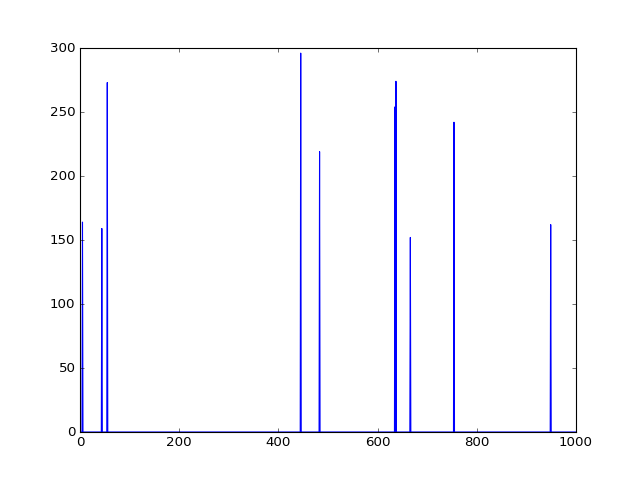

In [67]:
experience, steps_per_episode = train(env, experience, n_episodes=1000, max_steps=300, is_render=False)
pyplot.figure(2)
pyplot.plot(steps_per_episode)
pyplot.show()

(40, 40) (40, 40) (40, 40)


<IPython.core.display.Javascript object>


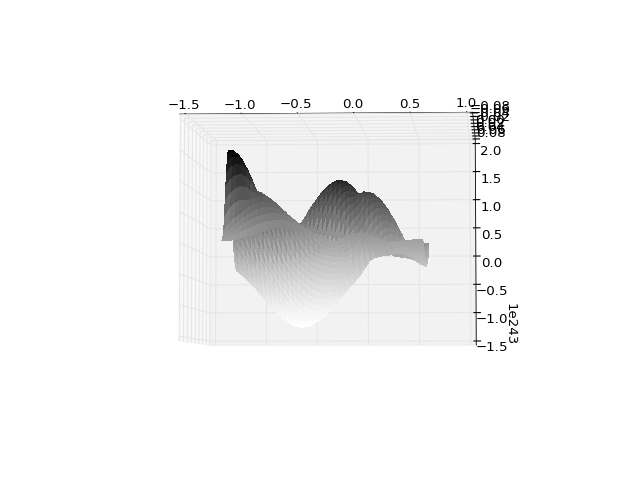

In [68]:
%matplotlib notebook
state_ranges = np.array([env.observation_space.low, env.observation_space.high])
driver.plot_2D_V(state_ranges, env.action_space, four_feature_vec, experience.theta)

In [69]:
experience, steps_per_episode = train(env, experience, n_episodes=30, max_steps=300, is_render=True)
#pyplot.plot(steps_per_episode)
#pyplot.show()

In [5]:
# What do I want?
#
#  - Write one procedure that just trains for a number of episodes.
#
#  - Write another procedure that keeps a running average of episode lengths and
#    stops training when the average doesn't change much anymore.
#
#  - Possibly write a procedure that returns the sequence of Q functions
#    resulting from training.

next_dtimestep = driver.make_next_dtimestep(env, linfa.think)
train_and_prep = driver.make_train_and_prep(env, next_dtimestep, linfa.wrapup)

episode_nr, last_avg, experience \
    = driver.train_until_converged(
          env=env,
          train_and_prep=train_and_prep,
          init_experience=experience,
          max_steps=100,
          max_episodes=10000,
          avg_window=200,
          max_diff=1)
print episode_nr, last_avg




cnts_dtimesteps = driver.cnts_dtimesteps_iter(env, train_and_prep, experience,
                                              100)

thetas = driver.train_return_thetas(cnts_dtimesteps, 1000)

sqes = 1.0 / experience.theta.shape[0] * np.sum(np.diff(thetas, axis=0) ** 2, axis=1)

pyplot.plot(sqes)
pyplot.show()

sums = np.sum(np.abs(thetas), axis=1)
pyplot.plot(sums)
pyplot.show()

with np.load("hard-earned-theta.npz") as data:
    old_theta = data['arr_0']
    print np.sum(old_theta)

#hard_earned_theta = np.copy(experience.theta)
#np.savez_compressed("hard-earned-theta", hard_earned_theta)

0 100.0


KeyboardInterrupt: 

In [4]:
env.close()